In [13]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# 1. Data Loading: Download and preprocess MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [14]:
# 2. Model Implementation
# Logistic Regression (single linear layer)
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.linear(x)

# MLP (one hidden layer)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

In [15]:
# 3. Training Module
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return losses


Using device: cuda


In [16]:
# 4. Testing Module
def model_test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Model Accuracy on Test Set: {accuracy:.2f}%')
    return accuracy

In [17]:
# Main Function
input_dim, output_dim, hidden_dim, num_epochs = 28*28, 10, 128, 10
criterion = nn.CrossEntropyLoss()

# Train Logistic Regression
model_lr = LogisticRegression(input_dim, output_dim).to(device)
optimizer_lr = optim.SGD(model_lr.parameters(), lr=0.1)
print("Training Logistic Regression Model:")
losses_lr = train_model(model_lr, train_loader, criterion, optimizer_lr, num_epochs=num_epochs)

# Train MLP
model_mlp = MLP(input_dim, hidden_dim, output_dim).to(device)
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=0.001)
print("\nTraining MLP Model:")
losses_mlp = train_model(model_mlp, train_loader, criterion, optimizer_mlp, num_epochs=num_epochs)

# Test both models
print("\nTesting Logistic Regression Model:")
accuracy_lr = model_test(model_lr, test_loader)
print("\nTesting MLP Model:")
accuracy_mlp = model_test(model_mlp, test_loader)


Training Logistic Regression Model:
Epoch [1/10], Loss: 0.6770
Epoch [2/10], Loss: 0.3826
Epoch [3/10], Loss: 0.3629
Epoch [4/10], Loss: 0.3444
Epoch [5/10], Loss: 0.3385
Epoch [6/10], Loss: 0.3310
Epoch [7/10], Loss: 0.3301
Epoch [8/10], Loss: 0.3235
Epoch [9/10], Loss: 0.3225
Epoch [10/10], Loss: 0.3239

Training MLP Model:
Epoch [1/10], Loss: 0.3782
Epoch [2/10], Loss: 0.1951
Epoch [3/10], Loss: 0.1396
Epoch [4/10], Loss: 0.1109
Epoch [5/10], Loss: 0.0971
Epoch [6/10], Loss: 0.0849
Epoch [7/10], Loss: 0.0763
Epoch [8/10], Loss: 0.0689
Epoch [9/10], Loss: 0.0617
Epoch [10/10], Loss: 0.0587

Testing Logistic Regression Model:
Model Accuracy on Test Set: 91.32%

Testing MLP Model:
Model Accuracy on Test Set: 97.35%


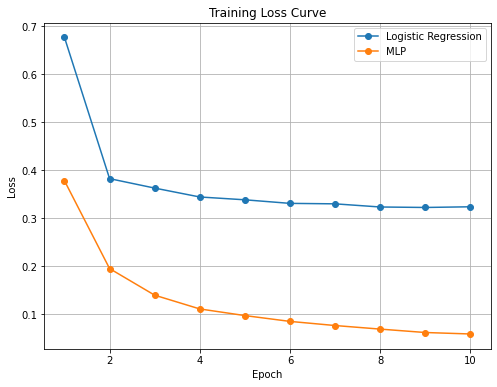

In [18]:
# 4. Plot Training Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), losses_lr, marker='o', label='Logistic Regression')
plt.plot(range(1, num_epochs+1), losses_mlp, marker='o', label='MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# Discussion and Conclusion
The Logistic Regression model converges to an average loss between 0.3 and 0.35 after training, achieving an accuracy around 88–92% on the test set. In contrast, the MLP model—with its non-linear hidden layer—reduces its loss to less than 0.1 and typically reaches test accuracies of 96–98%.

Although Logistic Regression trains quickly due to its simplicity, its linear nature limits its performance on complex data such as MNIST. The MLP, despite having a longer training time due to more parameters and non-linearities, better captures the intricate features of handwritten digits.

Further improvements might include hyperparameter tuning (e.g., adjusting learning rate or batch size), increasing the network depth, or employing convolutional neural networks (CNNs) to better exploit spatial information.